# Introduction

In this part I will show how to generate data using the simulation and display it. The simulation itself is unchanged compared to the previous notebook.

In [1]:
using Random
using DataFrames
using Gadfly

include("SimpleAgentEvents/src/SimpleAgentEvents.jl")

using .SimpleAgentEvents
using .SimpleAgentEvents.Scheduler

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/martin/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
@enum Status susceptible infected immune dead

mutable struct Person
    status :: Status
    contacts :: Vector{Person}
    x :: Float64
    y :: Float64
end

Person(x, y) = Person(susceptible, [], x, y)
Person(state, x, y) = Person(state, [], x, y)

Person

In [3]:
mutable struct Simulation
    scheduler :: PQScheduler{Float64}
    inf :: Float64
    rec :: Float64
    imm :: Float64
    mort :: Float64
    
    pop :: Vector{Person}
end

scheduler(sim :: Simulation) = sim.scheduler

Simulation(i, r, u, m) = Simulation(PQScheduler{Float64}(), i, r, u, m, [])

Simulation

In [4]:
@processes SIRm sim person::Person begin
    @poisson(sim.inf * count(p -> p.status == infected, person.contacts)) ~
        person.status == susceptible        => 
            begin
                person.status = infected
                [person; person.contacts]
            end

    @poisson(sim.rec)  ~
        person.status == infected           => 
            begin
                person.status = susceptible
                [person; person.contacts]
            end

    @poisson(sim.imm)  ~
        person.status == infected           => 
            begin
                person.status = immune
                person.contacts
            end
    
    @poisson(sim.mort)  ~
        person.status == infected           => 
            begin
                person.status = dead
                person.contacts
            end    
end


spawn_SIRm (generic function with 1 method)

In [5]:
include("setup_world.jl")
include("draw.jl")

draw_sim (generic function with 3 methods)

# Generating data

To do meaningful things with a simulation it will almost always be necessary to run it many times and generate output in some systematic way. 

For this purpose all code concerning the execution of the model - setup, running, data collection - is now contained in a single function that only receives parameter values, number of time steps and random seed as input. 

In [6]:
# this function runs the simulation on a grid world
function run_grid(inf, rec, imm, mort, x, y, tim, seed)
    # this part hasn't changed
    
    sim = Simulation(inf, rec, imm, mort)
    sim.pop = setup_grid(x, y)
    sim.pop[1].status = infected

    for person in sim.pop
        spawn_SIRm(person, sim)
    end

    Random.seed!(seed)
    
    # we create a few arrays to put the data in
    n_inf = Int[]
    n_susc = Int[]
    n_imm = Int[]
    n_dead = Int[]

    
    for t in  1:tim
        # run a time step
        upto!(sim.scheduler, time_now(sim.scheduler) + 1.0)
        
        # then count agents in all states and store the numbers in the arrays
        push!(n_inf, count(p -> p.status == infected, sim.pop))
        push!(n_susc, count(p -> p.status == susceptible, sim.pop))
        push!(n_imm, count(p -> p.status == immune, sim.pop))
        push!(n_dead, count(p -> p.status == dead, sim.pop))
    end
    
    # we bundle up the arrays in a DataFrame for easier handling
    DataFrame(inf = n_inf, susc = n_susc, imm = n_imm, dead = n_dead), sim
end


run_grid (generic function with 1 method)

In [8]:
# run the simulation on a random geometric graph
# *set near < 0.05!* (otherwise there will be MANY connections and
# the visualisation might crash your browser)
function run_geograph(inf, rec, imm, mort, N, near, nc, tim, seed)
    sim = Simulation(inf, rec, imm, mort)
    sim.pop = setup_geograph(N, near, nc)
    sim.pop[1].status = infected

    for person in sim.pop
        spawn_SIRm(person, sim)
    end

    Random.seed!(seed)
    
    n_inf = Int[]
    n_susc = Int[]
    n_imm = Int[]
    n_dead = Int[]

    
    for t in  1:tim
        upto!(sim.scheduler, time_now(sim.scheduler) + 1.0)
        push!(n_inf, count(p -> p.status == infected, sim.pop))
        push!(n_susc, count(p -> p.status == susceptible, sim.pop))
        push!(n_imm, count(p -> p.status == immune, sim.pop))
        push!(n_dead, count(p -> p.status == dead, sim.pop))
    end
    
    DataFrame(inf = n_inf, susc = n_susc, imm = n_imm, dead = n_dead), sim
end


run_geograph (generic function with 1 method)

We can now conveniently run both model versions and compare the output.

In [8]:
data, sim = run_grid(0.3, 0.1, 0.2, 0.1, 50, 50, 100, 42);

In [37]:
data2, sim2 = run_geograph(0.2, 0.01, 0.06, 0.00143, 2500, 0.05, 50, 120, 42);

The package we use for plotting is called Gadfly, it was heavily inspired by R's ggplot2.

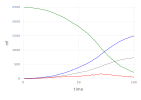

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly /home/martin/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


In [10]:
plot(data, layer(y=:inf, Geom.line, Theme(default_color="red")),
    layer(y=:susc, Geom.line, Theme(default_color="green")),
    layer(y=:imm, Geom.line, Theme(default_color="blue")),
    layer(y=:dead, Geom.line, Theme(default_color="grey")), 
    Guide.xlabel("time"))
    

In [27]:
data3 = copy(data2);

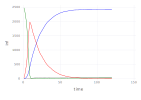

In [38]:
plot(data2, layer(y=:inf, Geom.line, Theme(default_color="red")),
    layer(y=:susc, Geom.line, Theme(default_color="green")),
    layer(y=:imm, Geom.line, Theme(default_color="blue")),
    layer(y=:dead, Geom.line, Theme(default_color="grey")), 
    Guide.xlabel("time"))

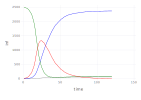

In [28]:
plot(data3, layer(y=:inf, Geom.line, Theme(default_color="red")),
    layer(y=:susc, Geom.line, Theme(default_color="green")),
    layer(y=:imm, Geom.line, Theme(default_color="blue")),
    layer(y=:dead, Geom.line, Theme(default_color="grey")), 
    Guide.xlabel("time"))

In [14]:
data2[:imm]

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:1
└ @ Core In[14]:1


120-element Array{Int64,1}:
    1
    3
    6
    9
   12
   14
   20
   25
   32
   39
   44
   64
   81
    ⋮
 2357
 2358
 2358
 2359
 2359
 2359
 2359
 2361
 2361
 2361
 2361
 2361

In [15]:
2361/2500 * 100

94.44

This is already quite interesting, but what we are usually interested in is the effect of changes in parameters on the model behaviour.

In [12]:
par_data = DataFrame(par_inf = Float64[], par_mort = Float64[], 
    n_inf = Int[], n_susc = Int[], n_imm = Int[], n_dead = Int[])

for inf in 0.1:0.2:2.0
    for mort in 0.1:0.2:2.0
        d, sim = run_grid(inf, 0.1, 0.2, mort, 50, 50, 100, 42)
        # get the last row
        d_last = last(d)
        push!(par_data, Float64[inf, mort, d_last[:inf], d_last[:susc], d_last[:imm], d_last[:dead]])
    end
end

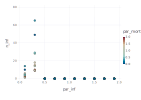

In [13]:
plot(par_data, y=:n_inf, x=:par_inf, Geom.point, color=:par_mort, Theme(default_color="red"))

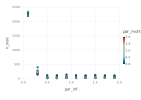

In [14]:
plot(par_data, y=:n_susc, x=:par_inf, color=:par_mort, Geom.point)

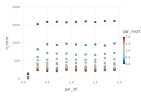

In [15]:
plot(par_data, y=:n_imm, x=:par_inf, color=:par_mort, Geom.point)

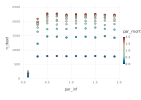

In [16]:
plot(par_data, y=:n_dead, x=:par_inf, color=:par_mort, Geom.point)

Let's try the same thing with the geo graph world.

In [17]:
par_data = DataFrame(par_inf = Float64[], par_mort = Float64[], 
    n_inf = Int[], n_susc = Int[], n_imm = Int[], n_dead = Int[])

for inf in 0.1:0.2:2.0
    for mort in 0.1:0.2:2.0
        d, sim = run_geograph(inf, 0.1, 0.2, mort, 2500, 0.03, 100, 100, 42)
        # get the last row
        d_last = last(d)
        # add last row and parameters to the data frame
        push!(par_data, Float64[inf, mort, d_last[:inf], d_last[:susc], d_last[:imm], d_last[:dead]])
    end
end

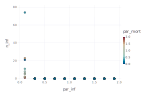

In [18]:
plot(par_data, y=:n_inf, x=:par_inf, Geom.point, color=:par_mort, Theme(default_color="red"))

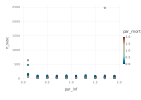

In [19]:
plot(par_data, y=:n_susc, x=:par_inf, color=:par_mort, Geom.point)

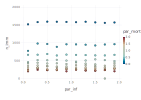

In [20]:
plot(par_data, y=:n_imm, x=:par_inf, color=:par_mort, Geom.point)

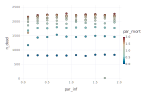

In [21]:
plot(par_data, y=:n_dead, x=:par_inf, color=:par_mort, Geom.point)